In [1]:
import sys
sys.path.append('../')

In [23]:
import numpy as np
import scanpy as sc
import pandas as pd
import multivae
from matplotlib import pyplot as plt
import umap
import seaborn as sns
import gc
import os
import tensorflow as tf
import keras

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%config InlineBackend.figure_format='retina'

In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [6]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# Load the Dataset

In [7]:
SCRNA_DIR = '../data/scRNA/'
SCATAC_DIR = '../data/scATAC/peaks/'

## scRNA

In [8]:
%time scrna = sc.read_h5ad(SCRNA_DIR + 'expressions.h5ad')
scrna = scrna[scrna.obs['condition'] == 'control']
scrna

CPU times: user 420 ms, sys: 188 ms, total: 608 ms
Wall time: 606 ms


View of AnnData object with n_obs × n_vars = 35582 × 3000 
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'cell_type', 'Barcode', 'condition'
    var: 'gene_name', 'gene_id', 'exonLength', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Group_colors', 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'

## scATAC

In [9]:
%time scatac = sc.read_h5ad(SCATAC_DIR + 'peaks-binary.h5ad')
scatac = scatac[scatac.obs['condition'] == 'control']
scatac

CPU times: user 1.26 s, sys: 2.16 s, total: 3.42 s
Wall time: 6.41 s


View of AnnData object with n_obs × n_vars = 35038 × 20002 
    obs: 'FRIP', 'TotalReads', 'Group', 'Barcode', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'cell_type', 'condition', 'nb_features'
    var: 'score', 'scoreQuantile', 'name', 'GC', 'n_cells', 'prop_shared_cells', 'variability_score'
    obsm: 'X_umap'

In [10]:
n_samples = min(scrna.shape[0], scatac.shape[0])
sample_indices = np.random.choice(range(n_samples), size=n_samples, replace=False)
scrna = scrna[sample_indices]
scatac = scatac[sample_indices]
print(scrna.shape, scatac.shape)

(35038, 3000) (35038, 20002)


# Train the model

In [11]:
network = multivae.archs.MultiTrVAE([scrna.shape[1], scatac.shape[1]],
                                    n_conditions=2,
                                    z_dimension=20,
                                    eta=1,
                                    alpha=0.0001,
                                    beta=10,
                                    output_activations=['relu', 'sigmoid'],
                                    reconstruction_losses=['mse', 'bce'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "multi_trvae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data_0 (InputLayer)             (None, 3000)         0                                            
__________________________________________________________________________________________________
encoder_labels_0 (InputLayer)   (None, 2)            0                                            
__________________________________________________________________________________________________
data_1 (InputLayer)             (None, 20002)        0                                            
__________________________________________________________________________________________________
encoder_labels_1 (InputLayer)   (None, 2)            0                                     

In [ ]:
history = network.train([scrna, scatac], n_epochs=1000, batch_size=256, verbose=2, lr_reducer=80, early_stop_limit=100)


Train on 28030 samples, validate on 7008 samples
Epoch 1/1000
 - 35s - loss: 221.0843 - decoder_0_loss: 220.2715 - decoder_1_loss: 0.4578 - decoder_0_kl_loss: 1.4302e-04 - decoder_0_modals_mmd_loss: 0.1247 - decoder_0_conditions_mmd_loss: 0.0000e+00 - decoder_1_kl_loss: 1.4302e-04 - decoder_1_modals_mmd_loss: 0.1247 - decoder_1_conditions_mmd_loss: 0.0000e+00 - val_loss: 202.9673 - val_decoder_0_loss: 202.1478 - val_decoder_1_loss: 0.5066 - val_decoder_0_kl_loss: 3.4765e-04 - val_decoder_0_modals_mmd_loss: 0.3519 - val_decoder_0_conditions_mmd_loss: 0.0000e+00 - val_decoder_1_kl_loss: 3.4765e-04 - val_decoder_1_modals_mmd_loss: 0.3519 - val_decoder_1_conditions_mmd_loss: 0.0000e+00
Epoch 2/1000
 - 29s - loss: 169.9182 - decoder_0_loss: 169.4128 - decoder_1_loss: 0.4170 - decoder_0_kl_loss: 1.7934e-04 - decoder_0_modals_mmd_loss: 0.0980 - decoder_0_conditions_mmd_loss: 0.0000e+00 - decoder_1_kl_loss: 1.7934e-04 - decoder_1_modals_mmd_loss: 0.0980 - decoder_1_conditions_mmd_loss: 0.0000

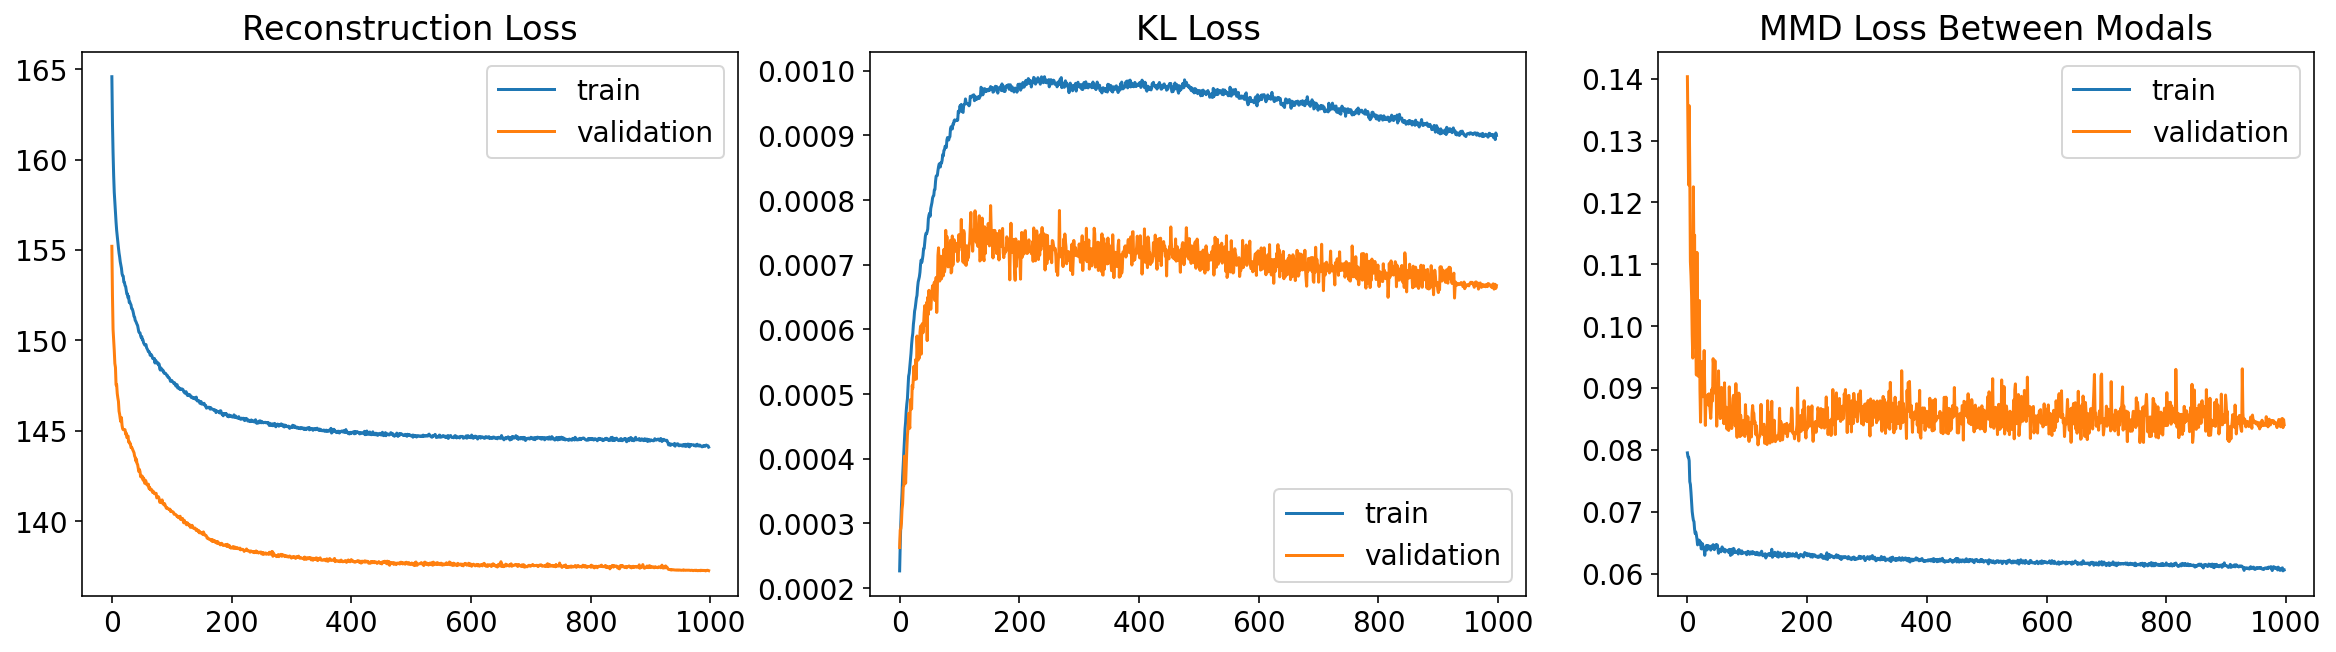

In [22]:
plt.figure(figsize=(20, 5));

plt.subplot(1, 3, 1);
plt.plot(history.history['loss'][2:], label='train');
plt.plot(history.history['val_loss'][2:], label='validation')
plt.title('Reconstruction Loss')
plt.legend();

plt.subplot(1, 3, 2);
plt.plot(history.history['decoder_0_kl_loss'][2:], label='train');
plt.plot(history.history['val_decoder_0_kl_loss'][2:], label='validation');
plt.title('KL Loss')
plt.legend();

plt.subplot(1, 3, 3);
plt.plot(history.history['decoder_0_modals_mmd_loss'][2:], label='train');
plt.plot(history.history['val_decoder_0_modals_mmd_loss'][2:], label='validation')
plt.title('MMD Loss Between Modals')
plt.legend();

# Visualization

## Latent space of scRNA-seq

In [15]:
scrna_encoder_labels, _ = multivae.utils.label_encoder(scrna, condition_key="condition")
scrna_latent = network.to_latent(scrna, scrna_encoder_labels, modal=0)

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anac

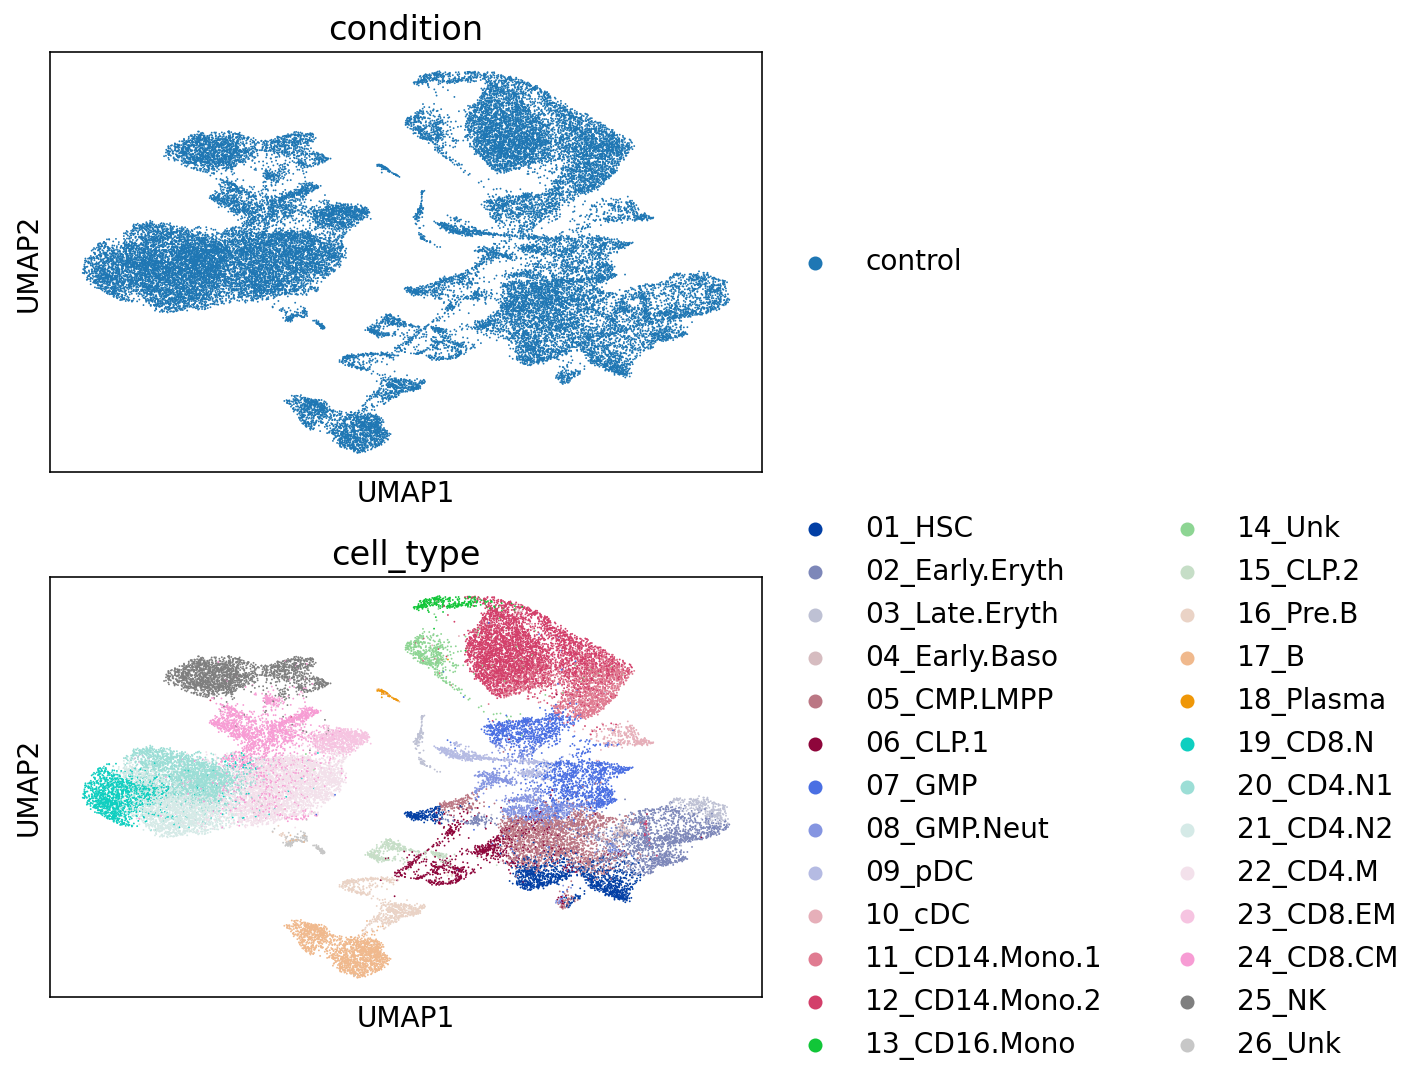

In [16]:
sc.pp.neighbors(scrna_latent, random_state=42)
sc.tl.umap(scrna_latent, random_state=42)
sc.pl.umap(scrna_latent, color=['condition', 'cell_type'], ncols=1)

## Latent space of scATAC-seq

In [17]:
scatac_encoder_labels, _ = multivae.utils.label_encoder(scatac, condition_key="condition")
scatac_latent = network.to_latent(scatac, scatac_encoder_labels, modal=1)

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


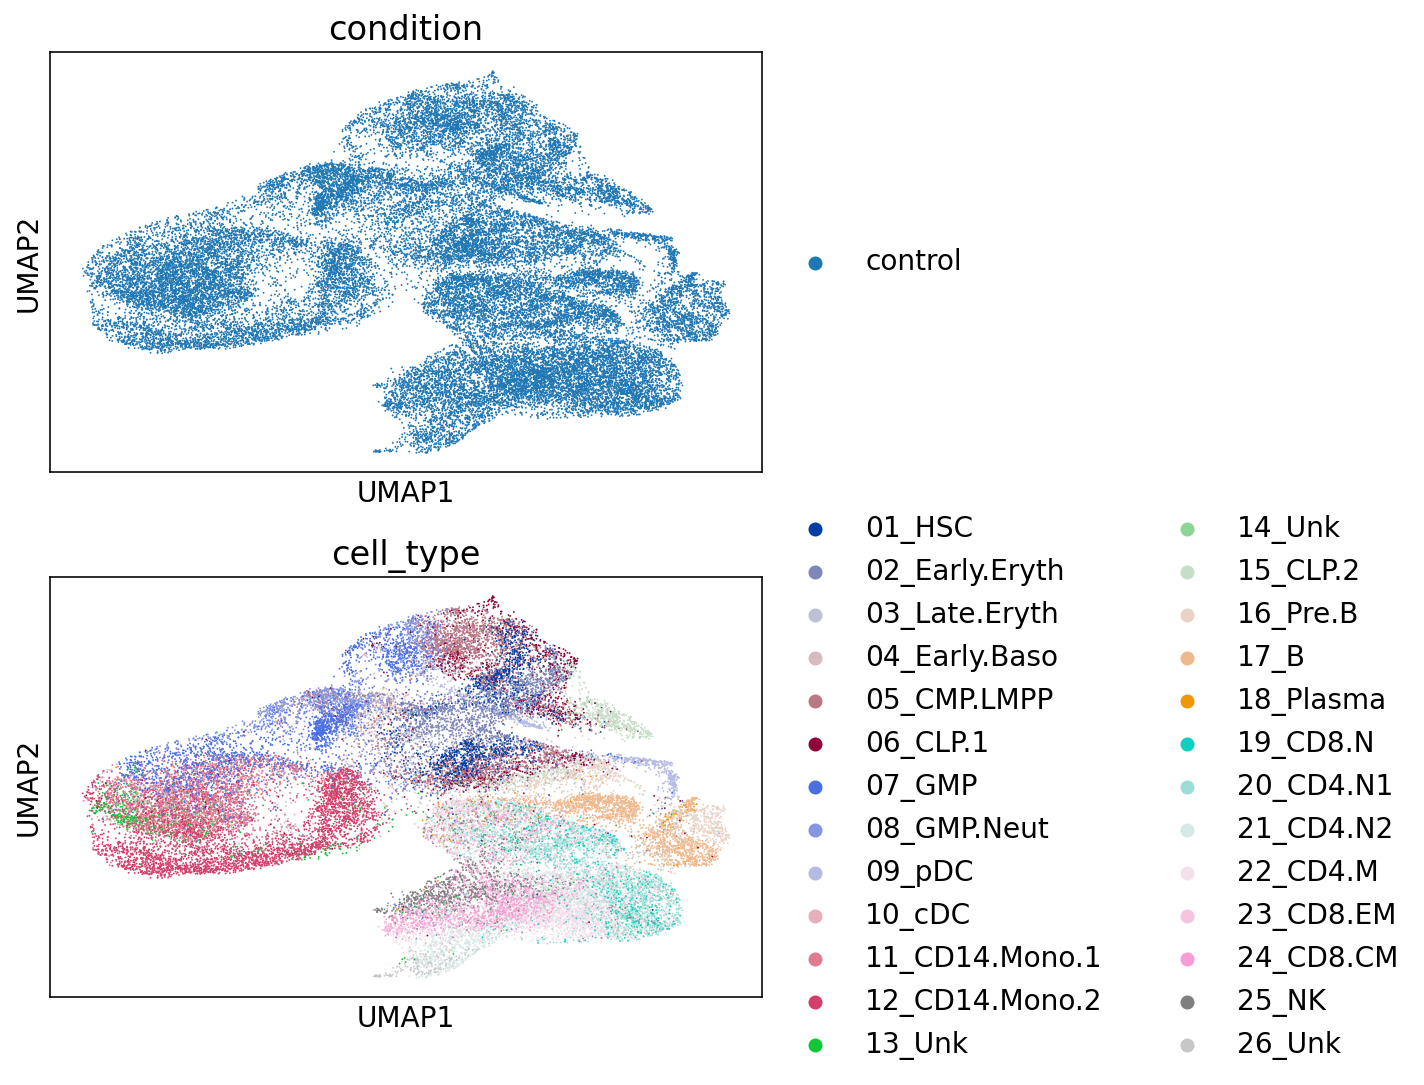

CPU times: user 1min 16s, sys: 1.24 s, total: 1min 18s
Wall time: 53.2 s


In [18]:
%%time
sc.pp.neighbors(scatac_latent, random_state=42)
sc.tl.umap(scatac_latent, random_state=42)
sc.pl.umap(scatac_latent, color=['condition', 'cell_type'], ncols=1)

## Latent space of both modalities

In [19]:
scall_latent = np.concatenate([scrna_latent.X, scatac_latent.X], axis=0)

scall_latent = sc.AnnData(scall_latent)
scrnaobs = scrna.obs.copy(deep=True)
scatacobs = scatac.obs.copy(deep=True)
scrnaobs['modality'] = 'scRNA-seq'
scatacobs['modality'] = 'scATAC-seq'

scall_latent.obs = pd.concat([scrnaobs, scatacobs])

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
... storing 'Group' as categorical
... storing 'cell_type' as categorical
... storing 'Barcode' as categorical
... storing 'modality' as categorical
... storing 'initialClusters' as categorical
... storing 'Clusters' as categorical


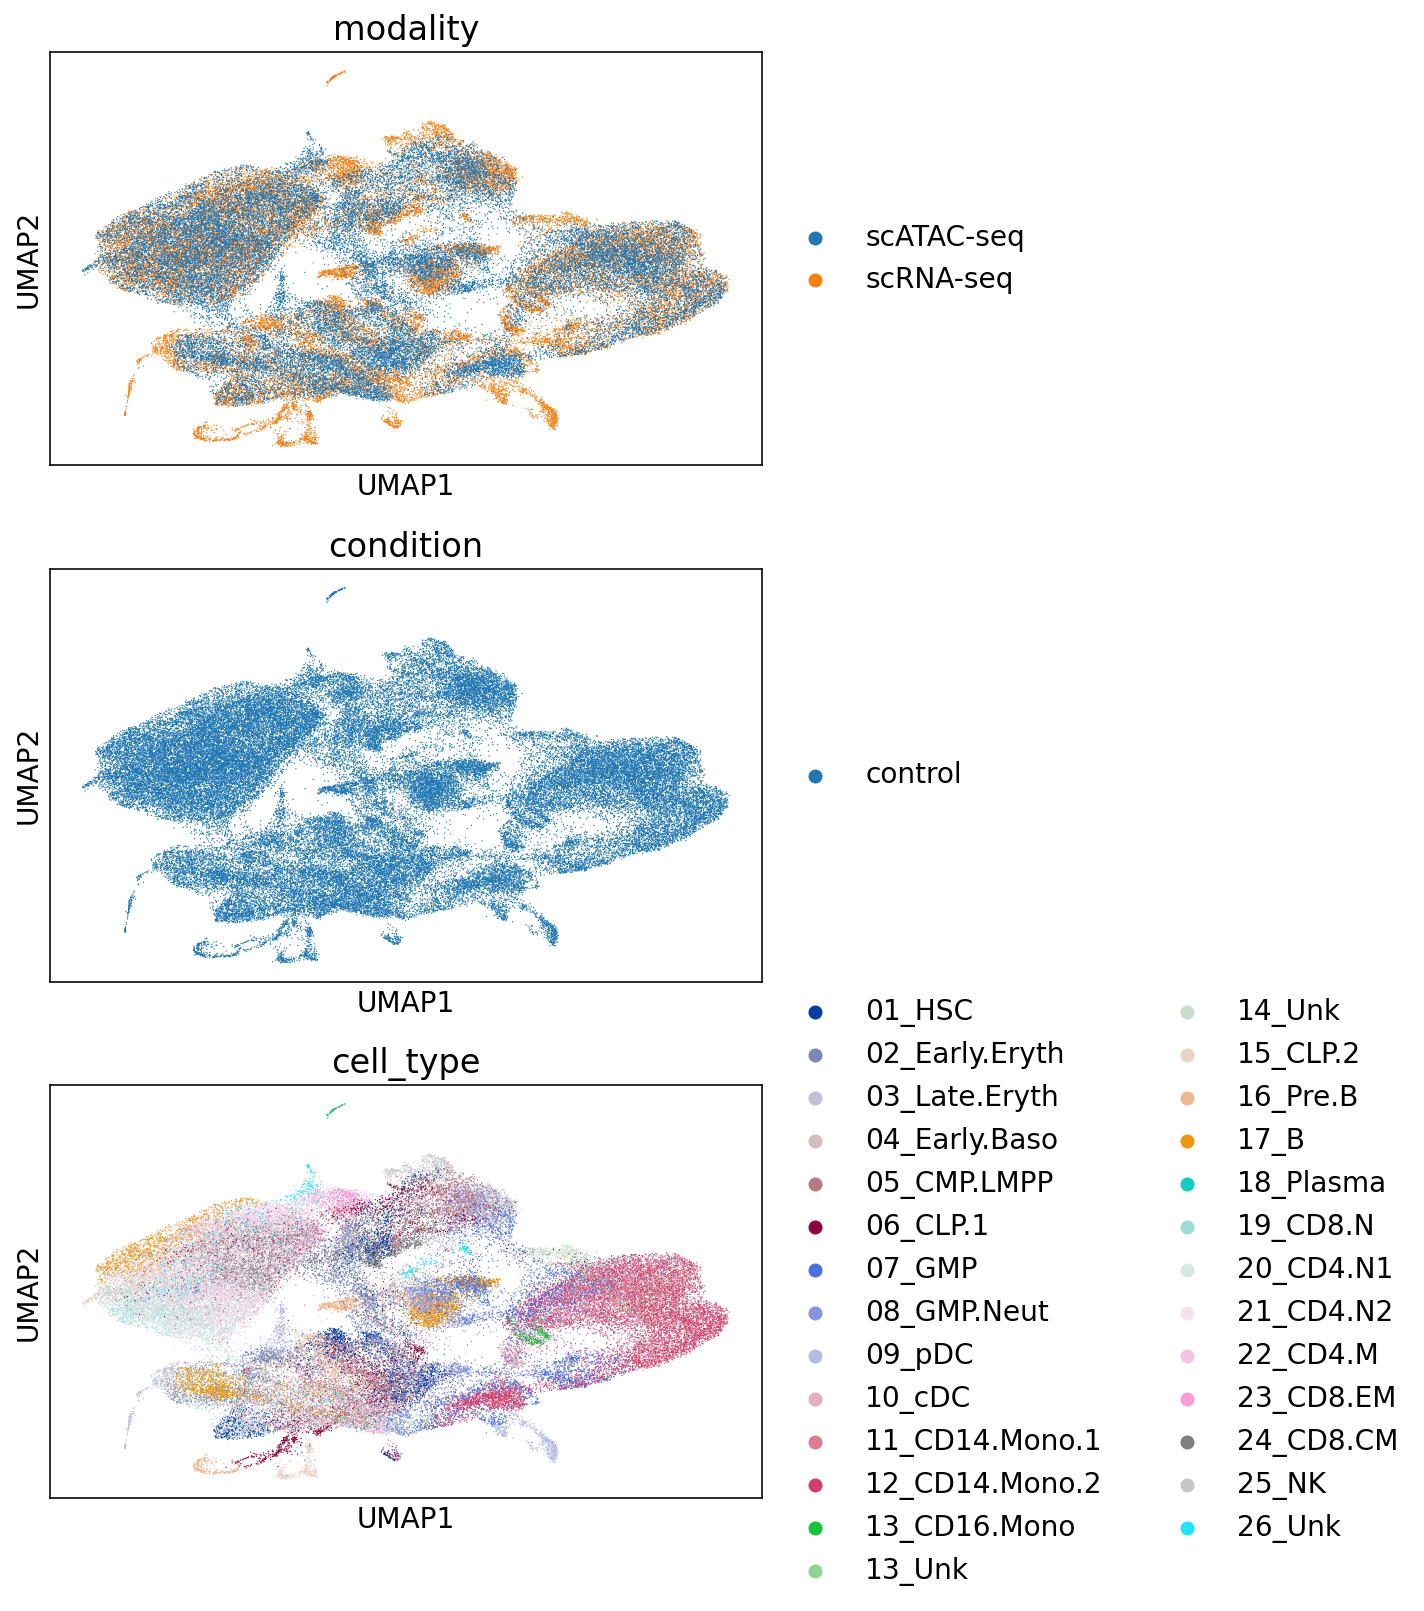

CPU times: user 5min 32s, sys: 6.38 s, total: 5min 38s
Wall time: 1min 59s


In [20]:
%%time
sc.pp.neighbors(scall_latent, random_state=42)
sc.tl.umap(scall_latent, random_state=42)
sc.pl.umap(scall_latent, color=['modality', 'condition', 'cell_type'], ncols=1)

# Classify Cell-types

In [49]:
classifier = keras.Sequential([
    keras.layers.Dense(128, input_shape=(20,), use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(.2),
    keras.layers.Dense(128, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(.2),
    keras.layers.Dense(128, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(.2),
    keras.layers.Dense(27, activation='softmax')
])

classifier.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 128)               2560      
_________________________________________________________________
batch_normalization_29 (Batc (None, 128)               512       
_________________________________________________________________
re_lu_17 (ReLU)              (None, 128)               0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               16384     
_________________________________________________________________
batch_normalization_30 (Batc (None, 128)               512       
_________________________________________________________________
re_lu_18 (ReLU)              (None, 128)              

In [50]:
cell_type_x = scall_latent.X
cell_type_y = keras.utils.to_categorical(scall_latent.obs['cell_type'].cat.codes, 27)

In [51]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier.fit(cell_type_x, cell_type_y, batch_size=32, epochs=300, verbose=2, validation_split=.2)

Train on 56060 samples, validate on 14016 samples
Epoch 1/300
 - 20s - loss: 1.4551 - accuracy: 0.5202 - val_loss: 1.5471 - val_accuracy: 0.3550
Epoch 2/300
 - 17s - loss: 1.1927 - accuracy: 0.5790 - val_loss: 1.3785 - val_accuracy: 0.4005
Epoch 3/300
 - 17s - loss: 1.1160 - accuracy: 0.6012 - val_loss: 1.2717 - val_accuracy: 0.4630
Epoch 4/300
 - 17s - loss: 1.0674 - accuracy: 0.6181 - val_loss: 1.3038 - val_accuracy: 0.4575
Epoch 5/300
 - 23s - loss: 1.0325 - accuracy: 0.6298 - val_loss: 1.1933 - val_accuracy: 0.4989
Epoch 6/300
 - 28s - loss: 1.0005 - accuracy: 0.6388 - val_loss: 1.1452 - val_accuracy: 0.5124
Epoch 7/300
 - 29s - loss: 0.9728 - accuracy: 0.6512 - val_loss: 1.1175 - val_accuracy: 0.5373
Epoch 8/300
 - 29s - loss: 0.9445 - accuracy: 0.6621 - val_loss: 1.0803 - val_accuracy: 0.5523
Epoch 9/300
 - 28s - loss: 0.9129 - accuracy: 0.6722 - val_loss: 1.0159 - val_accuracy: 0.5902
Epoch 10/300
 - 28s - loss: 0.8902 - accuracy: 0.6818 - val_loss: 1.0331 - val_accuracy: 0.5784